# Capstone 1 - Indepth Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import datetime
import seaborn as sns

In [2]:
# read in the data set, extract all the ticker symbols into a list
df = pd.read_csv('./data/all_cefs_clean.csv', parse_dates=['Date'], infer_datetime_format=True, index_col='ticker')
df.head()

# read in other fundamental fund data
fdf = pd.read_csv('./data/cef_fundem_clean.csv', index_col = 'Ticker')
fdf.head()

# merge the pricing data with the fundamental data, set multi index to ticker(level 0) and Date(level 1)
df1 = df.merge(fdf, how='left', left_index=True, right_index=True)
df1.rename_axis('ticker', inplace=True)
df1.set_index(['Date'], append=True, inplace=True)

# drop the precious metals funds because there are only 4 of them
df1.query('Category != "Precious Metals"', inplace=True)

# Add the Discount column calculated as (Close-NAV)/NAV
df1['Discount'] = (df1.Close - df1.NAV) / df1.NAV

# drop the last date row for all funds because not all funds had that data
df1.drop(index=pd.datetime(2019,3,6), level=1, inplace=True)

# final ticker symbols for all funds
tickers = df1.index.get_level_values(0).unique()

In [3]:
# function to annualize returns based on percent change and period (number of years)
def annualize(pchg, period):
    return (pchg + 1)**(1/period) - 1

In [4]:
# calculate 1, 3 , 5, and 10 year rolling returns
# shift the data back so that the returns are going forward
# calculate the Z-score for 1mo, 3mo, 6mo, 1yr, 2yr, 3yr
# calculate the 200 day moving average
# calculate trailing 1-yr and 10-year returns

ret_1 = []
ret_1past = []
ret_3 = []
ret_5 = []
ret_10 = []
ret_10past = []
Z1mo = []
Z3mo = []
Z6mo = []
Z1yr = []
Z2yr = []
Z3yr = []
ma200d = []
for t in tickers:
    ret_1.extend(df1.loc[t].Adj_Close.pct_change(252).shift(-252))
    ret_1past.extend(df1.loc[t].Adj_Close.pct_change(252))
    ret_3.extend(df1.loc[t].Adj_Close.pct_change(252*3).apply(annualize, args=(3,)).shift(-252*3))
    ret_5.extend(df1.loc[t].Adj_Close.pct_change(252*5).apply(annualize, args=(5,)).shift(-252*5))
    ret_10.extend(df1.loc[t].Adj_Close.pct_change(252*10).apply(annualize, args=(10,)).shift(-252*10))
    ret_10past.extend(df1.loc[t].Adj_Close.pct_change(252*10).apply(annualize, args=(10,)))
    Z1mo.extend((df1.loc[t, 'Discount'] - df1.loc[t, 'Discount'].rolling(21).mean()) / df1.loc[t, 'Discount'].rolling(21).std())
    Z3mo.extend((df1.loc[t, 'Discount'] - df1.loc[t, 'Discount'].rolling(21*3).mean()) / df1.loc[t, 'Discount'].rolling(21*3).std())
    Z6mo.extend((df1.loc[t, 'Discount'] - df1.loc[t, 'Discount'].rolling(21*6).mean()) / df1.loc[t, 'Discount'].rolling(21*6).std())
    Z1yr.extend((df1.loc[t, 'Discount'] - df1.loc[t, 'Discount'].rolling(252).mean()) / df1.loc[t, 'Discount'].rolling(252).std())
    Z2yr.extend((df1.loc[t, 'Discount'] - df1.loc[t, 'Discount'].rolling(252*2).mean()) / df1.loc[t, 'Discount'].rolling(252*2).std())
    Z3yr.extend((df1.loc[t, 'Discount'] - df1.loc[t, 'Discount'].rolling(252*3).mean()) / df1.loc[t, 'Discount'].rolling(252*3).std())
    ma200d.extend(df1.loc[t].Close.rolling(200).mean())
df1['ret_1'] = ret_1
df1['ret_1past'] = ret_1past
df1['ret_3'] = ret_3
df1['ret_5'] = ret_5
df1['ret_10'] = ret_10
df1['ret_10past'] = ret_10past
df1['Z1mo'] = Z1mo
df1['Z3mo'] = Z3mo
df1['Z6mo'] = Z6mo
df1['Z1yr'] = Z1yr
df1['Z2yr'] = Z2yr
df1['Z3yr'] = Z3yr
df1['ma200d'] = ma200d

# calculate how far from the 200 day moving average in percentage
df1['from200d'] = (df1.Close - df1.ma200d) / df1.ma200d

In [5]:
# get the mean values by Category for each date
df2 = df1.groupby(['Date','Category']).mean()
df2.reset_index(level=1, inplace=True)

In [6]:
# calculate the 1yr return versus the mean category returns
ret1vcat = []
ret1vcatp = []
for t in tickers:
    categ = df1.loc[t].Category[0]
    ret1vcat.extend(df1.loc[t].ret_1 - df2.loc[df1.loc[t].index[0]:].query('Category == @categ').ret_1)
    ret1vcatp.extend(df1.loc[t].ret_1past - df2.loc[df1.loc[t].index[0]:].query('Category == @categ').ret_1past)
df1['ret1vcat'] = ret1vcat
df1['ret1vcatp'] = ret1vcatp

In [7]:
disc_corr=[]
Z3yr_corr=[]
ret10p_corr = []
from200_corr = []
for t in tickers:
    disc_corr.append(list(df1.loc[t].corr().loc['Discount'][['ret_1', 'ret_3', 'ret_5', 'ret_10', 'ret1vcat']]))
    Z3yr_corr.append(list(df1.loc[t].corr().loc['Z3yr'][['ret_1', 'ret_3', 'ret_5', 'ret_10', 'ret1vcat']]))
    ret10p_corr.append(list(df1.loc[t].corr().loc['ret_10past'][['ret_1', 'ret_3', 'ret_5', 'ret_10', 'ret1vcat']]))
    from200_corr.append(list(df1.loc[t].corr().loc['from200d'][['ret_1', 'ret_3', 'ret_5', 'ret_10', 'ret1vcat']]))
disc_corrdf = pd.DataFrame(disc_corr, index = tickers, columns = ['ret1', 'ret3', 'ret5', 'ret10', 'ret1vcat'])
Z3yr_corrdf = pd.DataFrame(Z3yr_corr, index = tickers, columns = ['ret1', 'ret3', 'ret5', 'ret10', 'ret1vcat'])
ret10p_corrdf = pd.DataFrame(ret10p_corr, index = tickers, columns = ['ret1', 'ret3', 'ret5', 'ret10', 'ret1vcat'])
from200_corrdf = pd.DataFrame(from200_corr, index = tickers, columns = ['ret1', 'ret3', 'ret5', 'ret10', 'ret1vcat'])

In [8]:
disc_corrdf.nsmallest(5, 'ret1vcat')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
AOD,-0.425117,-0.702978,-0.510203,-0.493297,-0.879788
VGI,-0.646176,-0.554902,0.391346,NaN,-0.793456
DFP,-0.593974,-0.449662,-0.639775,NaN,-0.787038
BTT,-0.712985,-0.300167,-0.714306,NaN,-0.786817
AGD,-0.279355,-0.531941,-0.263265,0.000489,-0.765065


In [9]:
disc_corrdf.nsmallest(5, 'ret1')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
NID,-0.870679,-0.646807,-0.937441,NaN,-0.136797
BANX,-0.835578,-0.976332,-0.246830,NaN,-0.695605
NIQ,-0.823652,-0.541919,-0.958728,NaN,-0.138873
RGT,-0.776821,-0.629440,-0.429398,NaN,-0.634399
MMD,-0.755957,-0.652662,-0.735361,NaN,-0.226609


In [10]:
ret10p_corrdf.nlargest(5, 'ret1vcat')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
BGY,-0.733744,NaN,NaN,NaN,0.788214
FGB,0.385954,NaN,NaN,NaN,0.762145
GRX,-0.271546,NaN,NaN,NaN,0.606596
RIF,0.275595,-0.760783,0.653377,NaN,0.535934
HNW,-0.231526,NaN,NaN,NaN,0.532686


In [11]:
ret10p_corrdf.nlargest(5, 'ret1')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
CAF,0.759755,NaN,NaN,NaN,0.466509
FGB,0.385954,NaN,NaN,NaN,0.762145
IRL,0.304636,-0.126895,-0.495578,NaN,0.460622
RIF,0.275595,-0.760783,0.653377,NaN,0.535934
BKT,0.249453,0.287156,0.638984,NaN,-0.278761


In [12]:
from200_corrdf.nsmallest(5, 'ret1vcat')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
IID,-0.644560,-0.730798,-0.562961,-0.926176,-0.701065
CEN,-0.547235,-0.907810,NaN,NaN,-0.694892
FMN,-0.413983,-0.350797,-0.333027,-0.727024,-0.674589
NDP,-0.427477,-0.826922,0.243056,NaN,-0.642484
FEI,-0.520062,-0.678259,-0.000745,NaN,-0.637812


In [13]:
from200_corrdf.nsmallest(5, 'ret1')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
IID,-0.644560,-0.730798,-0.562961,-0.926176,-0.701065
MMD,-0.602448,-0.776185,-0.681439,NaN,-0.072824
NIQ,-0.569926,-0.219430,-0.852696,NaN,-0.147627
GUT,-0.560138,-0.307129,-0.323181,-0.669781,-0.252903
BGY,-0.558984,-0.802300,-0.571131,-0.968218,-0.400111


In [14]:
(disc_corrdf + from200_corrdf - ret10p_corrdf).div(3).nsmallest(5,'ret1vcat')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
BGY,-0.083418,NaN,NaN,NaN,-0.592794
FGB,-0.435965,NaN,NaN,NaN,-0.578525
IID,-0.231271,NaN,NaN,NaN,-0.533042
IGD,0.012949,-0.074262,NaN,NaN,-0.461938
IAE,0.050966,NaN,NaN,NaN,-0.418088


In [15]:
mpl.style.use('bmh')

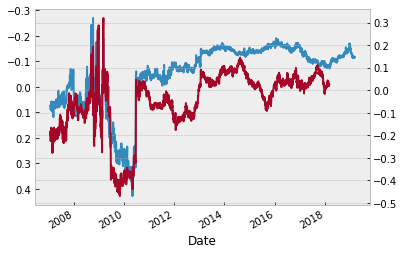

In [16]:
df1.loc['AOD'].Discount.plot()
plt.gca().invert_yaxis()
df1.loc['AOD'].ret1vcat.plot(secondary_y=True)

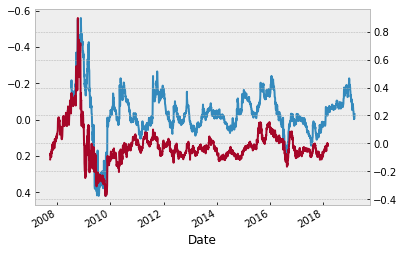

In [17]:
df1.loc['IID'].from200d.plot()
plt.gca().invert_yaxis()
df1.loc['IID'].ret1vcat.plot(secondary_y=True)

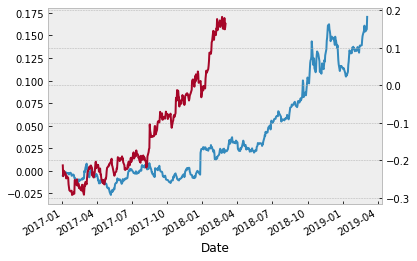

In [18]:
df1.loc['RIF'].loc['2017':].ret_10past.plot()
df1.loc['RIF'].loc['2017':].ret1vcat.plot(secondary_y=True)

In [19]:
# drop rows without 10-year past returns and 1-yr forward returns
df4 = df1.dropna(subset=['ret_10past', 'Discount', 'from200d', 'ret_1'])

tickers4 = df4.index.get_level_values(0).unique()

In [20]:
len(tickers4)

358

In [21]:
# redo correlations
disc_corr=[]
ret10p_corr = []
from200_corr = []
for t in tickers4:
    disc_corr.append(list(df4.loc[t].corr().loc['Discount'][['ret_1', 'ret_3', 'ret_5', 'ret_10', 'ret1vcat']]))  
    ret10p_corr.append(list(df4.loc[t].corr().loc['ret_10past'][['ret_1', 'ret_3', 'ret_5', 'ret_10', 'ret1vcat']]))
    from200_corr.append(list(df4.loc[t].corr().loc['from200d'][['ret_1', 'ret_3', 'ret_5', 'ret_10', 'ret1vcat']]))
disc_corrdf = pd.DataFrame(disc_corr, index = tickers4, columns = ['ret1', 'ret3', 'ret5', 'ret10', 'ret1vcat'])
ret10p_corrdf = pd.DataFrame(ret10p_corr, index = tickers4, columns = ['ret1', 'ret3', 'ret5', 'ret10', 'ret1vcat'])
from200_corrdf = pd.DataFrame(from200_corr, index = tickers4, columns = ['ret1', 'ret3', 'ret5', 'ret10', 'ret1vcat'])

In [22]:
disc_corrdf.nsmallest(5, 'ret1')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
GDL,-0.889059,NaN,NaN,NaN,-0.655063
AOD,-0.855981,NaN,NaN,NaN,0.288771
FEO,-0.847928,NaN,NaN,NaN,-0.646649
AGD,-0.844202,NaN,NaN,NaN,-0.172591
BKT,-0.843367,-0.693114,-0.866301,NaN,-0.479344


In [23]:
from200_corrdf.nsmallest(5, 'ret1')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
PKO,-0.831584,NaN,NaN,NaN,-0.392853
MHI,-0.789610,-0.800575,-0.677752,NaN,-0.527274
HTY,-0.789423,NaN,NaN,NaN,-0.803661
FMY,-0.768721,-0.798563,NaN,NaN,-0.070672
BTA,-0.765692,0.702025,NaN,NaN,-0.612440


In [24]:
ret10p_corrdf.nlargest(5, 'ret1')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
CAF,0.759755,NaN,NaN,NaN,0.466509
FGB,0.385954,NaN,NaN,NaN,0.762145
IRL,0.304636,-0.126895,-0.495578,NaN,0.460622
RIF,0.275595,-0.760783,0.653377,NaN,0.535934
BKT,0.249453,0.287156,0.638984,NaN,-0.278761


Text(0, 0.5, 'Discount to NAV')

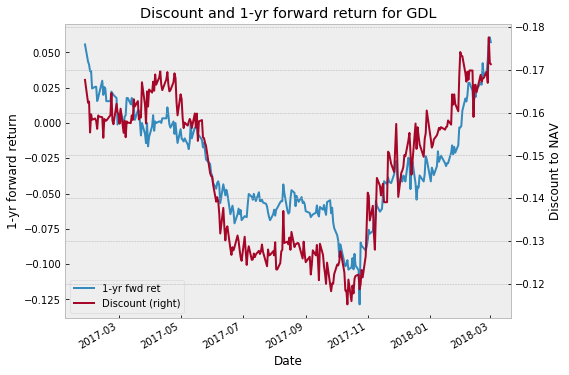

In [25]:
ax0 = df4.loc['GDL'].ret_1.plot(label='1-yr fwd ret',legend=True, figsize=(8,6))
ax1 = df4.loc['GDL'].Discount.plot(title='Discount and 1-yr forward return for GDL', legend=True, secondary_y=True)
ax1.invert_yaxis()
ax0.set_ylabel('1-yr forward return')
ax1.set_ylabel('Discount to NAV')


Text(0, 0.5, 'From 200dMA')

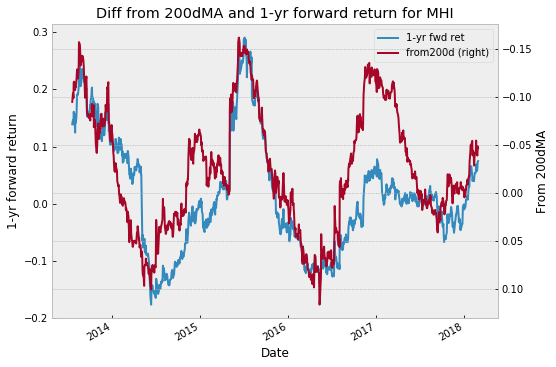

In [26]:
ax0 = df4.loc['MHI'].ret_1.plot(label='1-yr fwd ret',legend=True, figsize=(8,6))
ax1 = df4.loc['MHI'].from200d.plot(title='Diff from 200dMA and 1-yr forward return for MHI', legend=True, secondary_y=True)
ax1.invert_yaxis()
ax0.set_ylabel('1-yr forward return')
ax1.set_ylabel('From 200dMA')


Text(0, 0.5, '10-yr past return')

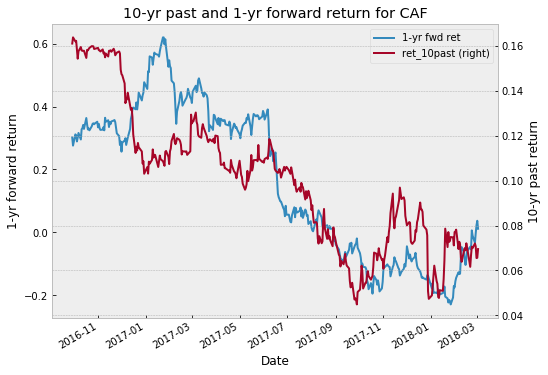

In [27]:
ax0 = df4.loc['CAF'].ret_1.plot(label='1-yr fwd ret',legend=True, figsize=(8,6))
ax1 = df4.loc['CAF'].ret_10past.plot(title='10-yr past and 1-yr forward return for CAF', legend=True, secondary_y=True)
ax0.set_ylabel('1-yr forward return')
ax1.set_ylabel('10-yr past return')


In [28]:
(disc_corrdf + from200_corrdf - ret10p_corrdf).div(3).nsmallest(5,'ret1')

,ret1,ret3,ret5,ret10,ret1vcat
ticker,,,,,
CAF,-0.642435,NaN,NaN,NaN,-0.413976
PKO,-0.454944,NaN,NaN,NaN,-0.162269
GGN,-0.445096,-0.262241,NaN,NaN,-0.528565
MGU,-0.417117,-0.089294,NaN,NaN,-0.477762
BKK,-0.357497,-0.111842,-0.388476,NaN,0.193655


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [31]:
df5 = df1.dropna(subset=['ret_10past'])

In [33]:
reg = LinearRegression()
regscore = []
for t in tickers4:
    X = np.array(df4.loc[t][['Discount', 'from200d', 'ret_10past']])
    y = df4.loc[t].ret_1
    tsize = int(len(X)*0.8)
    X_train = X[:tsize]
    X_test = X[tsize:]
    y_train = y[:tsize]
    y_test = y[tsize:]
    reg.fit(X_train, y_train)
    regscore.append(reg.score(X_test, y_test))
regscore = pd.Series(regscore, index=tickers4)


ticker
GCV    0.749600
SRV    0.745504
MFV    0.648179
JDD    0.627313
BTZ    0.593752
dtype: float64

In [34]:
pd.DataFrame(regscore.nlargest(5))

,0
ticker,
GCV,0.749600
SRV,0.745504
MFV,0.648179
JDD,0.627313
BTZ,0.593752


In [35]:
t = 'GCV'
X = np.array(df4.loc[t][['Discount', 'from200d', 'ret_10past']])
y = df4.loc[t].ret_1
tsize = int(len(X)*0.8)
X_train = X[:tsize]
X_test = X[tsize:]
y_train = y[:tsize]
y_test = y[tsize:]
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(np.array(df5.loc[t][['Discount', 'from200d', 'ret_10past']]))
yhat = pd.Series(yhat, index=df5.loc[t].Discount.index)


0.7496001860966884

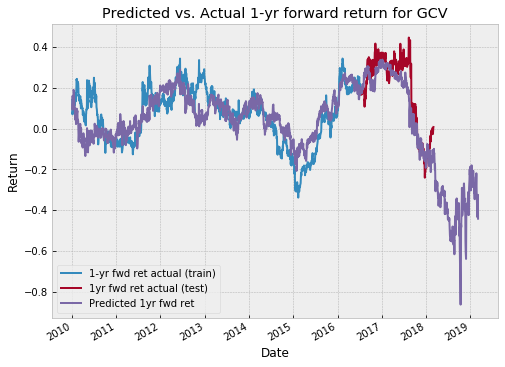

In [36]:
chart_title = "Predicted vs. Actual 1-yr forward return for " + t
ax = y_train.plot(figsize=(8,6), legend=True, label = '1-yr fwd ret actual (train)', title= chart_title)
plt.ylabel('Return')
y_test.plot(legend=True, label = '1yr fwd ret actual (test)')
yhat.plot(legend=True, label = 'Predicted 1yr fwd ret')
reg.score(X_test, y_test)

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
rfreg = RandomForestRegressor(n_estimators = 100)
rfscore = []
for t in tickers4:
    X = np.array(df4.loc[t][['Discount', 'from200d', 'ret_10past']])
    y = df4.loc[t].ret_1
    tsize = int(len(X)*0.9)
    X_train = X[:tsize]
    X_test = X[tsize:]
    y_train = y[:tsize]
    y_test = y[tsize:]
    rfreg.fit(X_train, y_train)
    rfscore.append(rfreg.score(X_test, y_test))
rfscore = pd.Series(rfscore, index=tickers4)


ticker
BTA     0.827483
EGF     0.807207
QQQX    0.515156
RMT     0.458036
PYN     0.446116
dtype: float64

In [39]:
pd.DataFrame(rfscore.nlargest(5))

,0
ticker,
BTA,0.827483
EGF,0.807207
QQQX,0.515156
RMT,0.458036
PYN,0.446116


In [40]:
t='BTA'
rfreg = RandomForestRegressor(n_estimators=100)
X = np.array(df4.loc[t][['Discount', 'from200d', 'ret_10past']])
y = df4.loc[t].ret_1
tsize = int(len(X)*0.9)
X_train = X[:tsize]
X_test = X[tsize:]
y_train = y[:tsize]
y_test = y[tsize:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rfreg.fit(X_train, y_train)
y_pred = rfreg.predict(X_test)
yhat = rfreg.predict(np.array(df5.loc[t][['Discount', 'from200d', 'ret_10past']]))
yhat = pd.Series(yhat, index=df5.loc[t].Discount.index)
rfreg.score(X_test, y_test)

0.8218624232043381

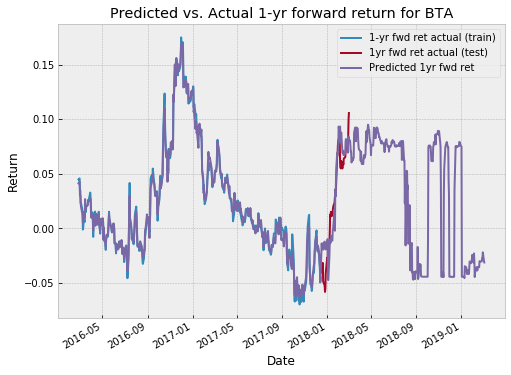

In [41]:

chart_title = "Predicted vs. Actual 1-yr forward return for " + t
ax = y_train.plot(figsize=(8,6), legend=True, label = '1-yr fwd ret actual (train)', title= chart_title)
plt.ylabel('Return')
y_test.plot(legend=True, label = '1yr fwd ret actual (test)')
yhat.plot(legend=True, label = 'Predicted 1yr fwd ret')
